In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, GridSearchCV

In [133]:
import warnings 
warnings.filterwarnings('ignore')

In [134]:
def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']

tickers = ['SMCI', 'NVDA', 'MU', 'AMD', 'QCOM']  
start_date = '2020-01-01'
end_date = '2024-01-01'

price_data = download_data(tickers, start_date, end_date)

returns = price_data.pct_change().dropna()

scaler = StandardScaler()
returns_standardized = pd.DataFrame(scaler.fit_transform(returns), index=returns.index, columns=returns.columns)

import pandas_datareader.data as web
factor_data = (web.DataReader('F-F_Research_Data_Factors', 'famafrench', start_date, end_date)[0].iloc[:,:-1])/100

factor_data.index = factor_data.index.to_timestamp(freq = 'M')

print(factor_data.head())
print(factor_data.index.min(), factor_data.index.max())

[*********************100%***********************]  5 of 5 completed
            Mkt-RF     SMB     HML
Date                              
2020-01-31 -0.0011 -0.0311 -0.0625
2020-02-29 -0.0813  0.0107 -0.0381
2020-03-31 -0.1339 -0.0483 -0.1387
2020-04-30  0.1365  0.0245 -0.0133
2020-05-31  0.0558  0.0247 -0.0488
2020-01-31 00:00:00 2024-01-31 00:00:00


In [135]:
mean = returns.mean()
variance = returns.var()
std_dev = returns.std()
kurtosis = returns.kurtosis()
skewness = returns.skew()

additional_stats = pd.DataFrame({
    'Mean': mean,
    'Variance': variance,
    'Std Dev': std_dev,
    'Kurtosis': kurtosis,
    'Skewness': skewness
})

print("\nAdditional Statistics:\n", additional_stats)


Additional Statistics:
           Mean  Variance   Std Dev   Kurtosis  Skewness
AMD   0.001661  0.001138  0.033734   2.182691  0.215183
MU    0.000868  0.000839  0.028964   3.519887 -0.076379
NVDA  0.002685  0.001167  0.034161   4.331565  0.424091
QCOM  0.000931  0.000709  0.026630   4.277509  0.218323
SMCI  0.003210  0.001493  0.038640  13.133564  1.026390


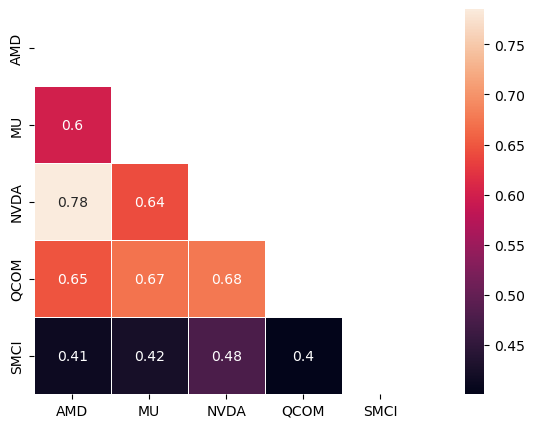

In [136]:
corr = returns.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,5))
sns.heatmap(corr, mask=mask,  square=True, linewidths=.5, annot=True)
plt.show()

In [137]:
returns.corr()

,AMD,MU,NVDA,QCOM,SMCI
AMD,1.000000,0.599814,0.784953,0.647249,0.414083
MU,0.599814,1.000000,0.641960,0.671738,0.424030
NVDA,0.784953,0.641960,1.000000,0.675903,0.476186
QCOM,0.647249,0.671738,0.675903,1.000000,0.400961
SMCI,0.414083,0.424030,0.476186,0.400961,1.000000


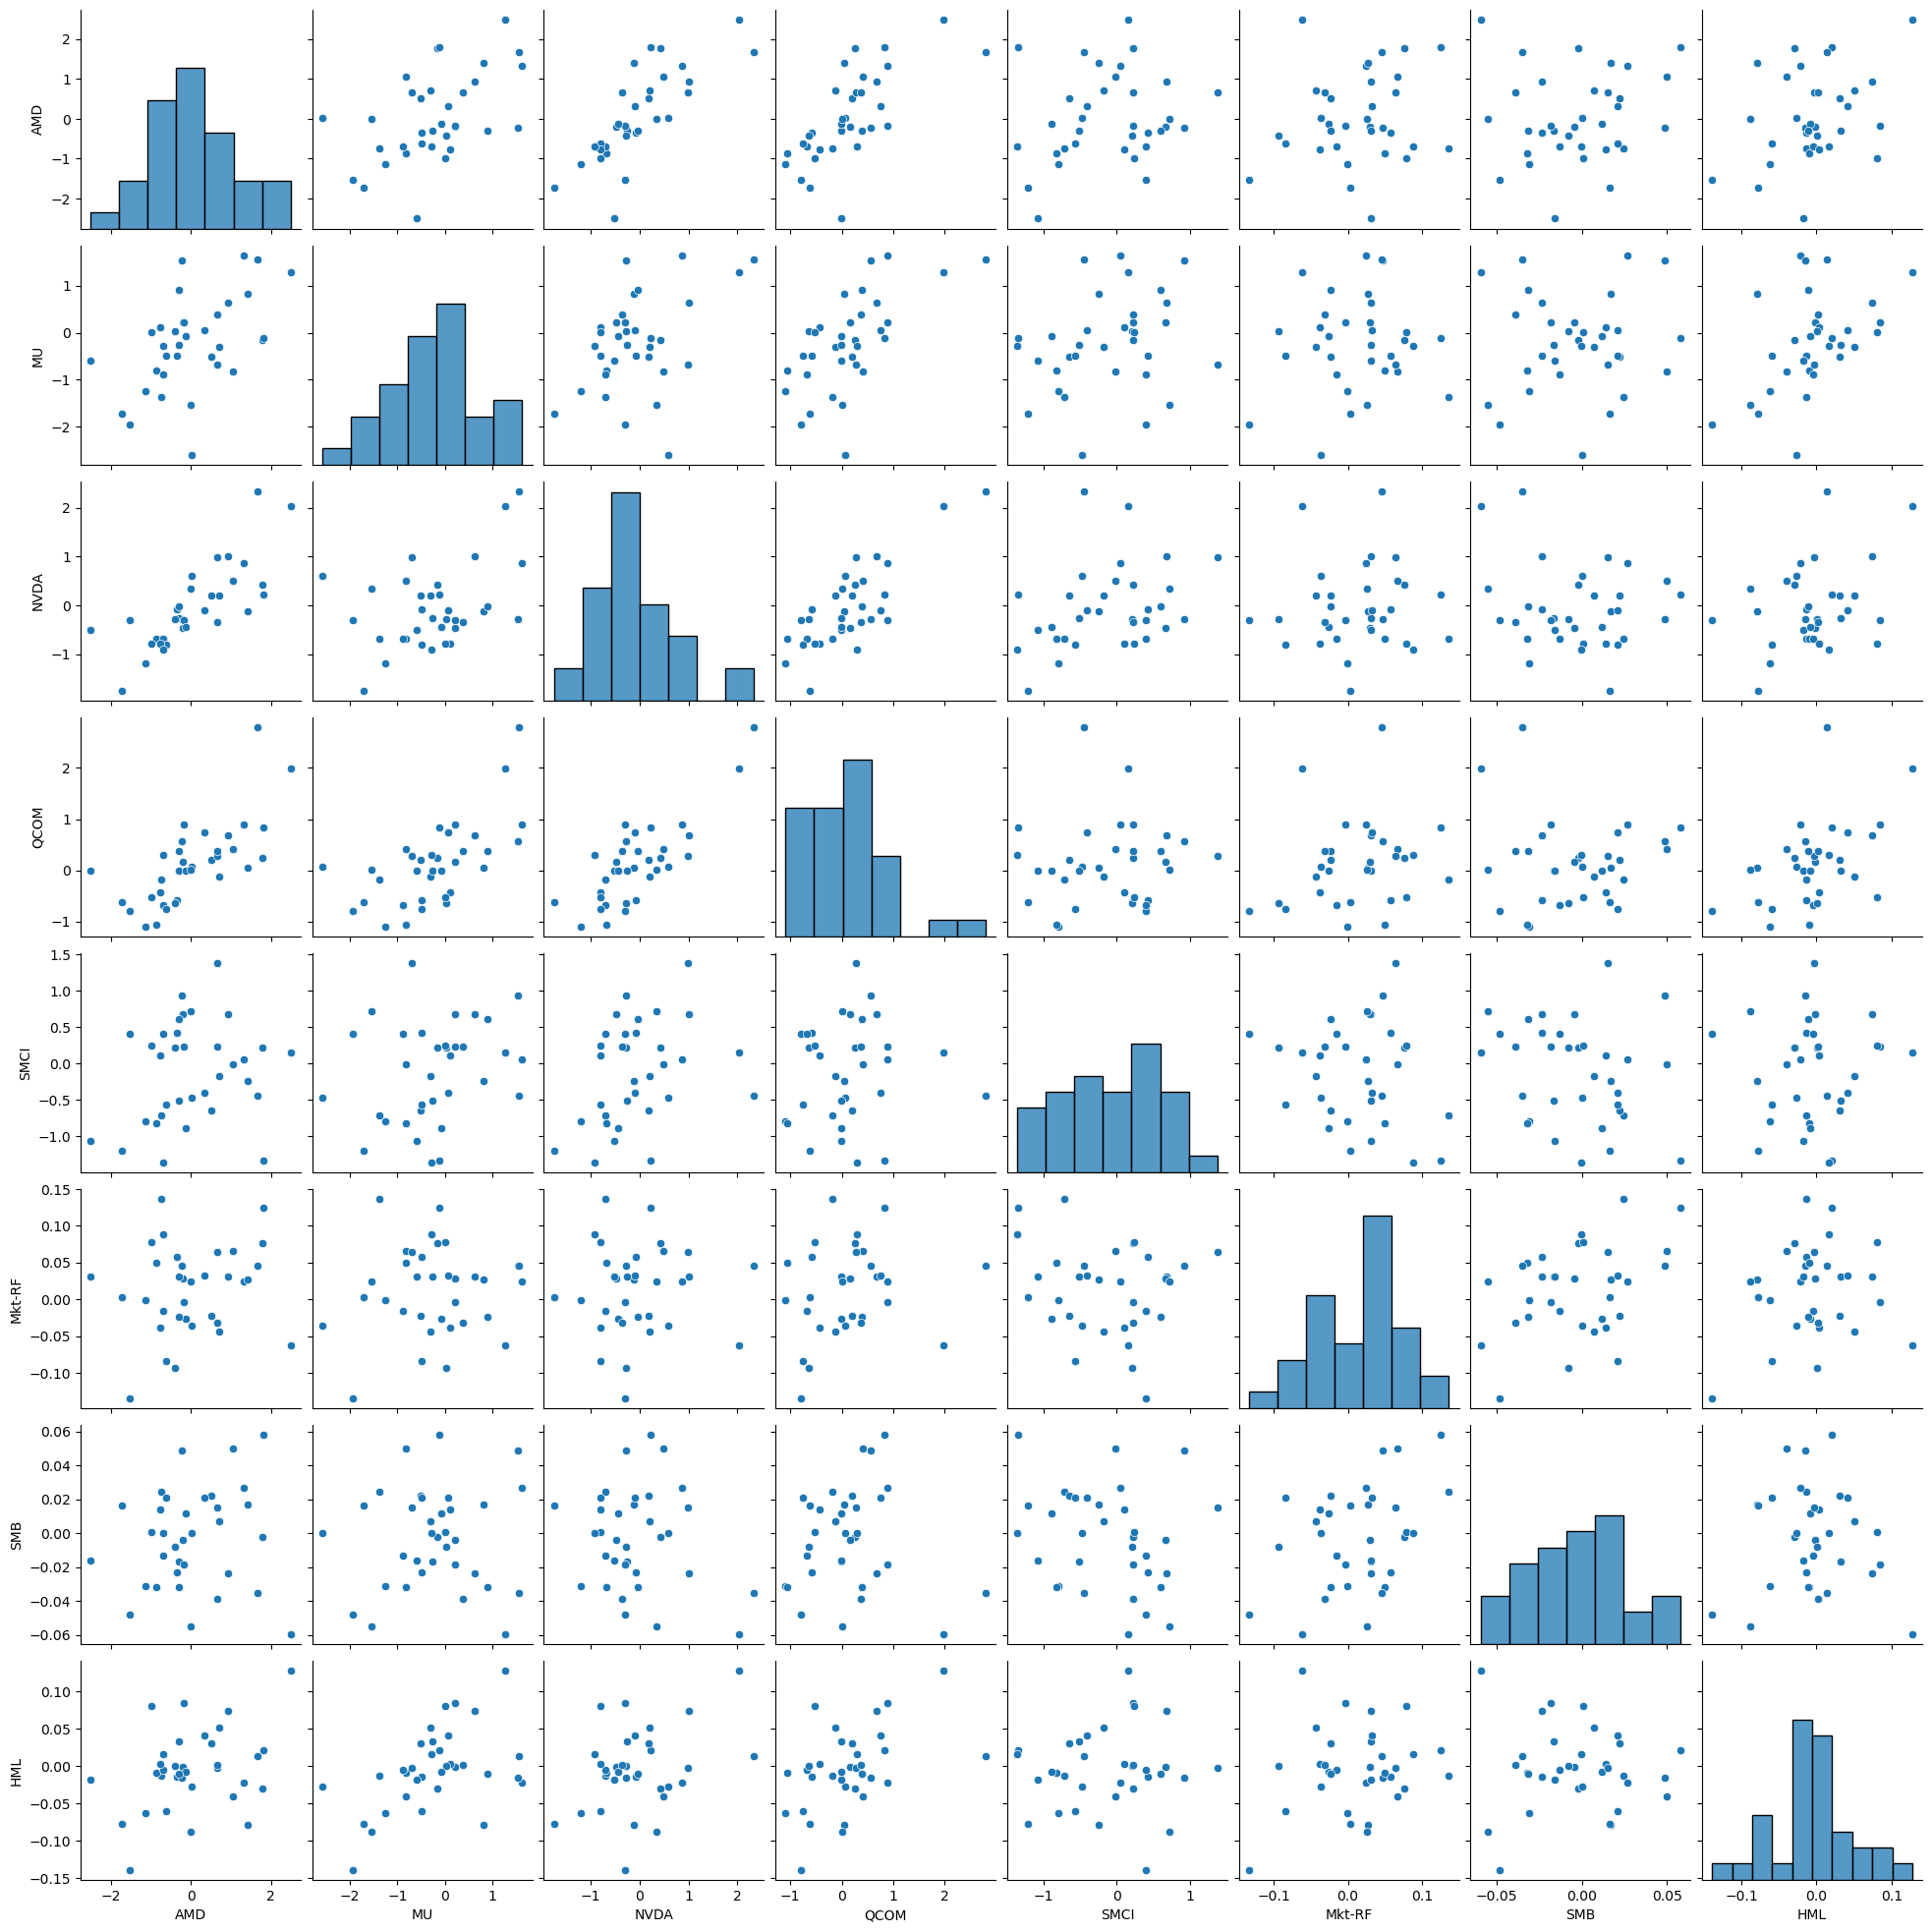

In [138]:
start_date = max(pd.to_datetime(start_date), factor_data.index.min()).strftime('%Y-%m-%d')
end_date = min(pd.to_datetime(end_date), factor_data.index.max()).strftime('%Y-%m-%d')

factor_data = factor_data[start_date:end_date]

data = pd.concat([returns_standardized, factor_data], axis=1).dropna()

sns.pairplot(data)
plt.show()

In [139]:
pca = PCA(n_components=3)
pca_factors = pca.fit_transform(data[factor_data.columns])
pca_df = pd.DataFrame(pca_factors, index=data.index, columns=[f'PC{i+1}' for i in range(pca_factors.shape[1])])

print(f'Explained variance by each component: {pca.explained_variance_ratio_}')

X = sm.add_constant(data[factor_data.columns])
factor_models = {}

for asset in returns.columns:
    y = data[asset]
    model = sm.OLS(y, X).fit()
    factor_models[asset] = model
    print(asset, model.summary())


Explained variance by each component: [0.54246038 0.36211083 0.0954288 ]
AMD                             OLS Regression Results                            
Dep. Variable:                    AMD   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     1.758
Date:                Mon, 17 Jun 2024   Prob (F-statistic):              0.176
Time:                        19:07:48   Log-Likelihood:                -48.465
No. Observations:                  34   AIC:                             104.9
Df Residuals:                      30   BIC:                             111.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [140]:
X_ml = data[factor_data.columns]
y_ml = data[returns.columns]

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42)

rf = RandomForestRegressor()
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7]}
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
predictions = best_rf.predict(X_test)

print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'max_depth': 3, 'n_estimators': 200}


In [141]:
pd.DataFrame(predictions)

,0,1,2,3,4
0,-0.024332,-0.097728,-0.126600,0.005653,0.063957
1,0.078789,-0.008974,0.027210,0.079937,0.164468
2,-0.290667,-0.505593,-0.188671,-0.079103,-0.300547
3,-0.029081,-0.466934,-0.109789,-0.097301,-0.047431
4,0.662360,-0.016259,0.192220,0.311027,-0.196298
5,-0.132256,-0.141316,-0.210461,-0.087874,0.045867
6,0.181368,-0.313511,-0.007204,0.031759,0.004432


In [142]:
pd.DataFrame(predictions)

,0,1,2,3,4
0,-0.024332,-0.097728,-0.126600,0.005653,0.063957
1,0.078789,-0.008974,0.027210,0.079937,0.164468
2,-0.290667,-0.505593,-0.188671,-0.079103,-0.300547
3,-0.029081,-0.466934,-0.109789,-0.097301,-0.047431
4,0.662360,-0.016259,0.192220,0.311027,-0.196298
5,-0.132256,-0.141316,-0.210461,-0.087874,0.045867
6,0.181368,-0.313511,-0.007204,0.031759,0.004432


In [143]:
def calculate_weights(predictions, risk_aversion=3):
    expected_returns = predictions.mean(axis=0)
    cov_matrix = np.cov(predictions, rowvar=False)
    
    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns) 
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = portfolio_return / portfolio_volatility
        return -sharpe_ratio  # Minimize negative Sharpe ratio
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bounds = [(0.1, 1) for _ in range(len(expected_returns))]
    
    initial_weights = np.array([1 / len(expected_returns)] * len(expected_returns))
    
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

weights = calculate_weights(predictions)
print(weights)

[0.6 0.1 0.1 0.1 0.1]


In [144]:
def backtest_strategy(prices, weights, initial_cash=100, commission=0.001):
    portfolio = pd.DataFrame(index=prices.index, columns=['Portfolio Value'])
    cash = initial_cash
    n_assets = len(weights)
    positions = np.zeros(n_assets)
    
    for i in range(1, len(prices)):
        portfolio_value = cash + np.sum(positions * prices.iloc[i, :])
        portfolio.iloc[i] = portfolio_value
        
        daily_returns = (prices.iloc[i, :] / prices.iloc[i-1, :]) - 1
        
        new_positions = (weights * portfolio_value) / prices.iloc[i, :]
        transaction_costs = np.sum(np.abs(new_positions - positions) * prices.iloc[i, :] * commission)
        positions = new_positions
        cash = portfolio_value - np.sum(positions * prices.iloc[i, :]) - transaction_costs
        
    portfolio.iloc[0] = initial_cash
    return portfolio

initial_cash = 100
portfolio_value = backtest_strategy(price_data, weights)
portfolio_value.dropna(inplace=True)

final_value = portfolio_value.iloc[-1, 0]
annualized_return = (final_value / initial_cash) ** (252 / len(portfolio_value)) - 1
sharpe_ratio = returns.mean().dot(weights) / (returns.std().dot(weights)) * np.sqrt(252)
max_drawdown = (portfolio_value.cummax() - portfolio_value).max()

print(f'Final portfolio value: {final_value:.2f}')
print(f'Annualized Return: {annualized_return:.2f}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Maximum Drawdown: {max_drawdown}')

Final portfolio value: 388.68
Annualized Return: 0.41
Sharpe Ratio: 0.85
Maximum Drawdown: Portfolio Value    169.364662
dtype: object


In [145]:
portfolio_value.pct_change().std()

Portfolio Value    0.028821
dtype: float64

In [146]:
# Buy and Hold

daily_NAV = returns.add(1).cumprod().mul(100).dot(weights)
daily_NAV_ret = daily_NAV.pct_change()
sharpe_ratio = daily_NAV_ret.mean() / daily_NAV_ret.std()
vol = daily_NAV_ret.std()
print(f'Portfolio Value: {daily_NAV[-1]:.4f} | Volatility = {vol:.4f} | Sharpe Ratio: {sharpe_ratio:.4f} ')

Portfolio Value: 416.8599 | Volatility = 0.0298 | Sharpe Ratio: 0.0630 


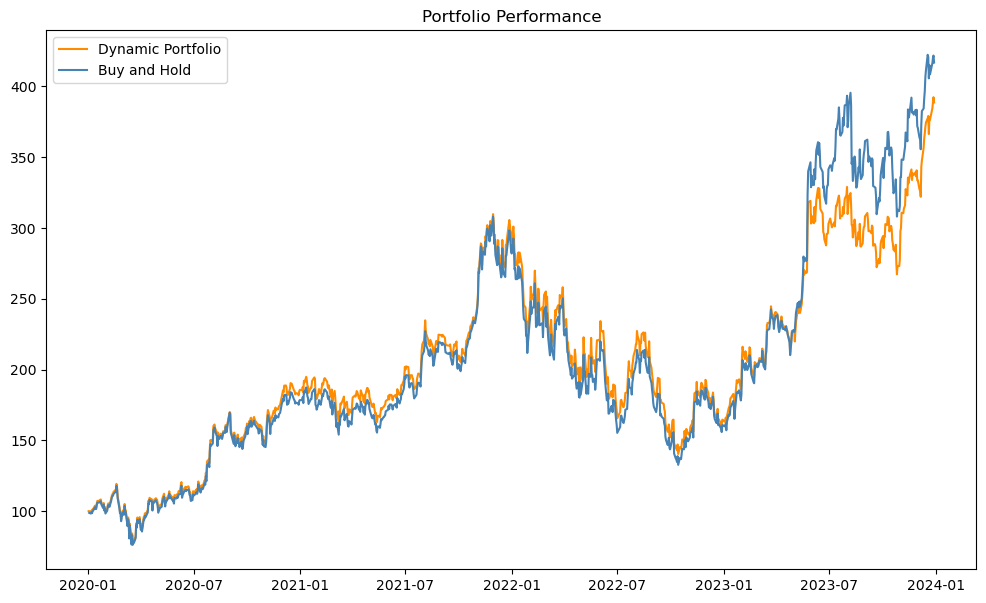

In [147]:
plt.figure(figsize=(12, 7))
plt.plot(portfolio_value, label='Dynamic Portfolio', color = 'darkorange')
plt.plot(daily_NAV, label='Buy and Hold', color = 'steelblue')
plt.legend()
plt.title('Portfolio Performance')
plt.show()

In [148]:
rollvol_bh = daily_NAV.rolling(30).std()
rollvol_ds = portfolio_value.rolling(30).std()


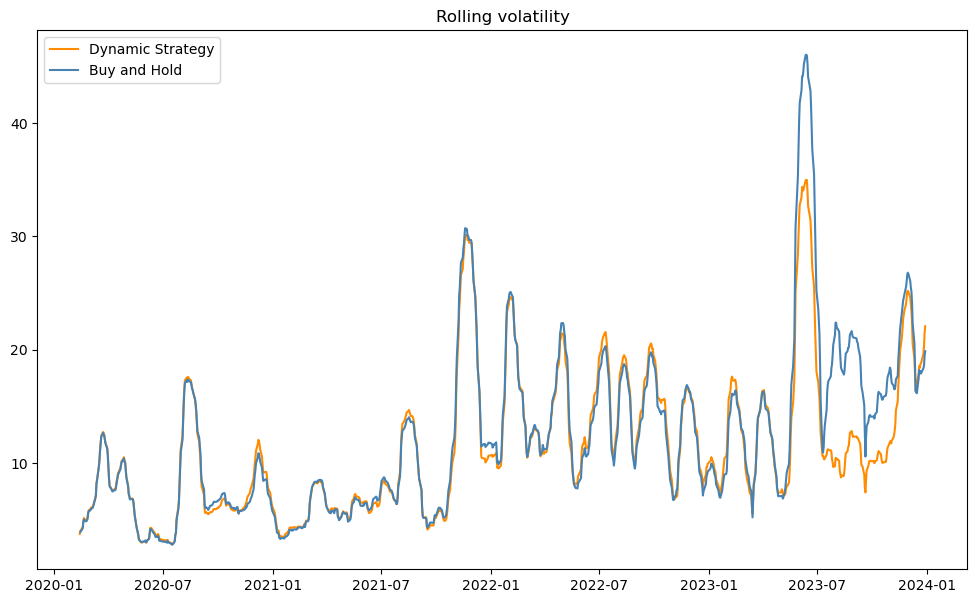

In [149]:
plt.figure(figsize = (12,7))
plt.plot(rollvol_ds, label = 'Dynamic Strategy', color = 'darkorange')
plt.plot(rollvol_bh, label = 'Buy and Hold', color = 'steelblue')
plt.legend()
plt.title('Rolling volatility')
plt.show()